In [143]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils

sns.set_theme()

print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

GPUs für die Berechnung: 0


In [144]:
#Metadaten einlesen
df = pd.read_csv("NIHMS841832-supplement-1.csv")

#Ergebnisse des Feature Tables einlesen
feature = pd.read_csv('feature_table.txt', sep='\t').T
feature = feature[1:][:-1]

In [145]:
#Gesunde Kontrollgruppe
HC = df[df.ibd_subtype.eq("HC")]

y = []
for row in feature.index:
    if any(True for val in HC['sample_name'] if val == row):
        y.append(1)
    else:
        y.append(0)

X = feature.iloc[:, :].values

In [146]:
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
1629.SubjectIBD335,0.0,345.0,0.0,0.0,0.0,0.0,412.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,353.0
1629.SubjectIBD643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1629.SubjectIBD539,0.0,2869.0,0.0,0.0,0.0,0.0,1665.0,0.0,0.0,0.0,...,0.0,746.0,0.0,0.0,0.0,3.0,21.0,0.0,0.0,88919.0
1629.SubjectIBD078,0.0,5.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1629.SubjectIBD671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


[[116   7]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       123
           1       0.12      0.08      0.10        13

    accuracy                           0.86       136
   macro avg       0.52      0.51      0.51       136
weighted avg       0.83      0.86      0.85       136



<AxesSubplot:>

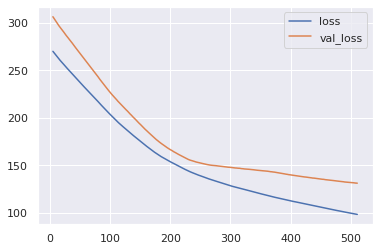

In [147]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=64,
    restore_best_weights=True
)

# Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
# Dropout führt allem Anschein nach zu schlechterem F1
# Weniger LUs führen zu besseren Ergebnissen
network = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    #layers.Dropout(rate=0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(rate=0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# NN kompilieren
network.compile(
    optimizer='adadelta',
    loss='binary_crossentropy',
    metrics=[keras.metrics.Accuracy()]
)

# NN trainieren
history = network.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=512,
    callbacks=[early_stopping],
    verbose=0
)

# Scores berechnen
history_df = pd.DataFrame(history.history)

y_pred = np.floor(network.predict(X_test))
report = sklearn.metrics.classification_report(y_test, y_pred)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(report)

history_df.loc[5:, ['loss', 'val_loss']].plot()